In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun
from scipy.optimize import minimize_scalar

MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"

db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)

print(min(db_MC_neutrinos["energy"]), max(db_MC_neutrinos["energy"]))


-1.0 9999.715384397996


In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model = (pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
)

#Power of energy to scale the flux
mag = 3

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Initialize empty grid
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = np.zeros_like(e_grid)


#Sum fluxes, calculated for different angles
for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))

    flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))

    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_total'] += (mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))

log_bincenters = mceq_run.e_grid[(mceq_run.e_grid > 1) & (mceq_run.e_grid < 1e4)]

#average the results
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = flux[frac]/float(len(angles))
    flux[frac] = np.array([val for i, val in enumerate(flux[frac]) if e_grid[i] in log_bincenters and val != 0])

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [3]:
db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 50)                   #at least 50 GeV
                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos


# log_bins are bin centers, so calculate bin edges for log spacing
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], log_binedges, [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))  # extrapolate edges

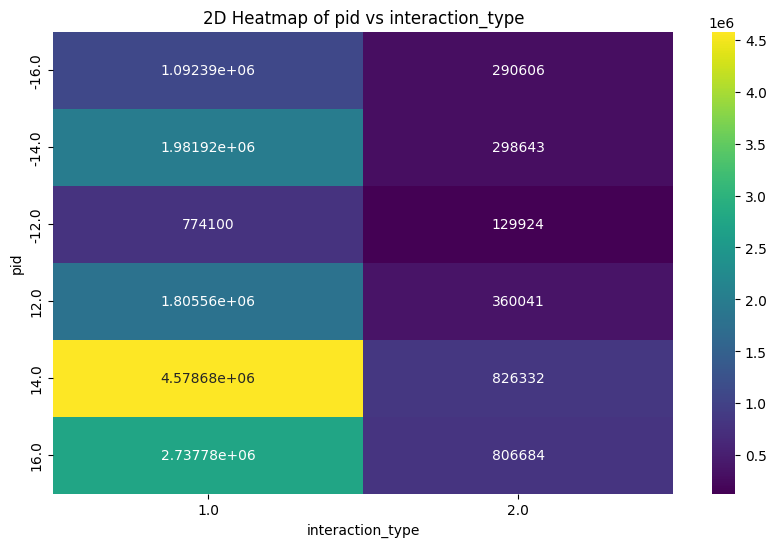

6560599
1124975


In [4]:
import seaborn as sns

plt.figure(figsize=(10, 6))
heatmap_data = pd.crosstab(db_MC_neutrinos_cut['pid'], db_MC_neutrinos_cut['interaction_type'])
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis')
plt.xlabel('interaction_type')
plt.ylabel('pid')
plt.title('2D Heatmap of pid vs interaction_type')
plt.show()

print(sum((abs(db_MC_neutrinos_cut['pid']) == 14) & (db_MC_neutrinos_cut['interaction_type'] == 1)))
print(sum((abs(db_MC_neutrinos_cut['pid']) == 14) & (db_MC_neutrinos_cut['interaction_type'] == 2)))

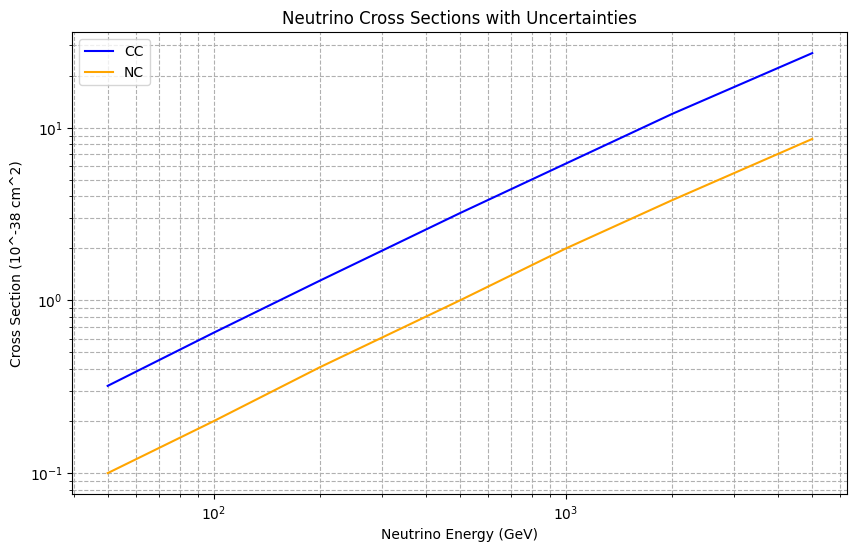

In [5]:
energies_list = [50, 100, 200, 500, 1000, 2000, 5000]  # GeV
sigma_cc = [0.32, 0.65, 1.3, 3.2, 6.2, 12, 27]
sigma_cc_unc = [(4.1, -2.3), (3.8, -2.0), (3.5, -1.8), (3.2, -1.7), (3.0, -1.6), (2.7, -1.6), (2.3, -1.5)]  # uncs in (up %, down %)
sigma_nc = [0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]
sigma_nc_unc = [(3.8, -1.9), (3.5, -1.8), (3.2, -1.6), (2.9, -1.5), (2.7, -1.4), (2.4, -1.3), (2.1, -1.3)]  # uncs in (up %, down %)

sigma_anti_cc = [0.15, 0.33, 0.69, 1.8, 3.6, 7.0, 17]
sigma_anti_cc_unc = [(15.0, -9.0), (13.3, -7.4), (11.9, -6.5), (10.5, -5.7), (9.4, -5.2), (8.3, -4.6), (6.5, -3.7)]  # uncs in (up %, down %)
sigma_anti_nc = [0.05, 0.11, 0.23, 0.61, 1.20, 2.4, 5.8]
sigma_anti_nc_unc = [(12.0, -6.4), (10.7, -5.7), (9.6, -5.1), (8.6, -4.6), (7.8, -4.2), (7.0, -3.8), (5.7, -3.2)]  # uncs in (up %, down %)

plt.figure(figsize=(10, 6))
plt.plot(energies_list, sigma_cc, label='CC', color='blue')
plt.plot(energies_list, sigma_nc, label='NC', color='orange')
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Neutrino Energy (GeV)')
plt.ylabel('Cross Section (10^-38 cm^2)')
plt.title('Neutrino Cross Sections with Uncertainties')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



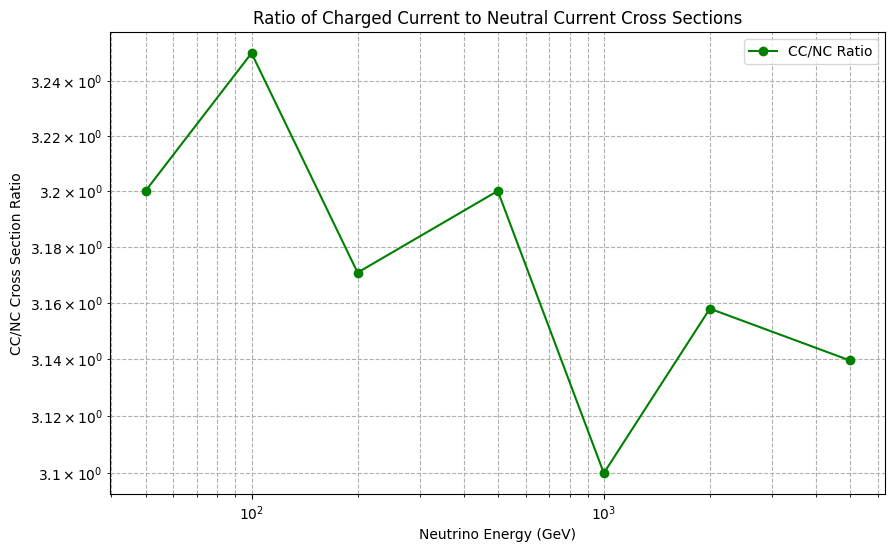

In [6]:
ratio_CC_NC = np.array(sigma_cc) / np.array(sigma_nc)

plt.figure(figsize=(10, 6))
plt.plot(energies_list, ratio_CC_NC, label='CC/NC Ratio',color='green', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Neutrino Energy (GeV)')
plt.ylabel('CC/NC Cross Section Ratio')
plt.title('Ratio of Charged Current to Neutral Current Cross Sections')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [8]:
# Calculate expected flux ratios from MCEq
mu_to_all_expected = flux['numu_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])
e_to_all_expected = flux['nue_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])
tau_to_all_expected = flux['nutau_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])

# Interpolate expected ratios to your energy grid
from scipy.interpolate import interp1d

# Create interpolation functions for CC/NC ratio
cc_nc_interp = interp1d(energies_list, ratio_CC_NC, kind='linear', 
                        bounds_error=False, fill_value='extrapolate')

# Calculate weights per bin (much faster!)
def calculate_bin_weights(df):
    # Initialize weights array
    weights = np.ones(len(df))
    
    # Add bin index to dataframe for vectorized operations
    df_temp = df.copy()
    df_temp['bin_idx'] = np.digitize(df_temp['energy'], log_binedges) - 1
    df_temp['bin_idx'] = np.clip(df_temp['bin_idx'], 0, len(log_bincenters)-1)
    
    print(f"Processing {len(df)} events across {len(log_bincenters)} bins...")
    
    # Calculate weights for each bin
    for bin_idx in range(len(log_bincenters)):
        # Get events in this bin
        bin_mask = df_temp['bin_idx'] == bin_idx
        bin_events = df_temp[bin_mask]
        
        if len(bin_events) == 0:
            continue
            
        # Get expected ratios at this energy
        bin_energy = log_bincenters[bin_idx]
        mu_expected = mu_to_all_expected[bin_idx] if bin_idx < len(mu_to_all_expected) else mu_to_all_expected[-1]
        e_expected = e_to_all_expected[bin_idx] if bin_idx < len(e_to_all_expected) else e_to_all_expected[-1]
        tau_expected = tau_to_all_expected[bin_idx] if bin_idx < len(tau_to_all_expected) else tau_to_all_expected[-1]
        
        # Get expected CC/NC ratio at this energy
        #cc_nc_expected = cc_nc_interp(bin_energy)
        
        # Calculate observed ratios in this bin
        n_mu = np.sum(np.abs(bin_events['pid']) == 14)
        n_e = np.sum(np.abs(bin_events['pid']) == 12)
        n_tau = np.sum(np.abs(bin_events['pid']) == 16)
        total_events = n_mu + n_e + n_tau
        
        n_cc = np.sum(bin_events['interaction_type'] == 1)
        n_nc = np.sum(bin_events['interaction_type'] == 2)
        
        if total_events == 0 or n_nc == 0:
            continue
            
        mu_observed = n_mu / total_events
        e_observed = n_e / total_events
        tau_observed = n_tau / total_events
        #cc_nc_observed = n_cc / n_nc if n_nc > 0 else 1.0
        
        # Calculate flavor weights for this bin
        mu_flavor_weight = mu_expected / mu_observed if mu_observed > 0 else 1.0
        e_flavor_weight = e_expected / e_observed if e_observed > 0 else 1.0
        tau_flavor_weight = tau_expected / tau_observed if tau_observed > 0 else 1.0
        
        # Calculate interaction weights for this bin
        #cc_interaction_weight = cc_nc_expected / cc_nc_observed if cc_nc_observed > 0 else 1.0
        #nc_interaction_weight = 1.0  # NC is the reference
        
        # Apply weights to all events in this bin
        bin_indices = bin_events.index
        
        # Flavor weights
        mu_mask = np.abs(bin_events['pid']) == 14
        e_mask = np.abs(bin_events['pid']) == 12
        tau_mask = np.abs(bin_events['pid']) == 16
        
        # Interaction weights
        #cc_mask = bin_events['interaction_type'] == 1
        #nc_mask = bin_events['interaction_type'] == 2
        
        # Combine flavor and interaction weights
        for idx in bin_indices:
            flavor_weight = 1.0
            interaction_weight = 1.0
            
            if mu_mask.loc[idx]:
                flavor_weight = mu_flavor_weight
            elif e_mask.loc[idx]:
                flavor_weight = e_flavor_weight
            elif tau_mask.loc[idx]:
                flavor_weight = tau_flavor_weight
                
            #if cc_mask.loc[idx]:
            #    interaction_weight = cc_interaction_weight
            #elif nc_mask.loc[idx]:
            #    interaction_weight = nc_interaction_weight
                
            weights[df.index.get_loc(idx)] = flavor_weight * interaction_weight
    
    return weights

# Apply weights to your dataset
print("Calculating bin-based weights...")
db_MC_neutrinos_cut['reweight_factor'] = calculate_bin_weights(db_MC_neutrinos_cut)

# Combine with existing weights if they exist
if 'total_osc_weight' in db_MC_neutrinos_cut.columns:
    db_MC_neutrinos_cut['final_weight'] = db_MC_neutrinos_cut['total_osc_weight'] * db_MC_neutrinos_cut['reweight_factor']
else:
    db_MC_neutrinos_cut['final_weight'] = db_MC_neutrinos_cut['reweight_factor']

print("Reweighting completed!")
print(f"Average reweight factor: {db_MC_neutrinos_cut['reweight_factor'].mean():.3f}")
print(f"Reweight factor range: {db_MC_neutrinos_cut['reweight_factor'].min():.3f} - {db_MC_neutrinos_cut['reweight_factor'].max():.3f}")

Calculating bin-based weights...
Processing 15682654 events across 40 bins...
Reweighting completed!
Average reweight factor: 1.000
Reweight factor range: 0.000 - 2.071


/tmp/ipykernel_95219/476793682.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_MC_neutrinos_cut['reweight_factor'] = calculate_bin_weights(db_MC_neutrinos_cut)
/tmp/ipykernel_95219/476793682.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_MC_neutrinos_cut['final_weight'] = db_MC_neutrinos_cut['total_osc_weight'] * db_MC_neutrinos_cut['reweight_factor']


In [9]:
# Check weighted flavor ratios
weighted_mu = db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 14]['final_weight'].sum()
weighted_e = db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 12]['final_weight'].sum()
weighted_tau = db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 16]['final_weight'].sum()
total_weighted = weighted_mu + weighted_e + weighted_tau

print(f"Weighted flavor fractions:")
print(f"Muon: {weighted_mu/total_weighted:.3f}")
print(f"Electron: {weighted_e/total_weighted:.3f}")
print(f"Tau: {weighted_tau/total_weighted:.3f}")

Weighted flavor fractions:
Muon: 0.964
Electron: 0.036
Tau: 0.000


In [ ]:
mu_to_all = flux['numu_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(log_bincenters, mu_to_all, marker='o', label='MCEq', color='tab:blue')

ax[0].set_ylabel('Fraction')
ax[0].set_title('Muon Neutrino to All Neutrinos Ratio vs Energy')

ax[0].plot(log_bincenters, true_muon_to_total_list, marker='o', label='CSV_truth', color='tab:green')
ax[0].set_xlim([1, 10000])
ax[0].set_xscale('log')
ax[0].legend()

bins = np.logspace(np.log10(db_MC_neutrinos_cut['energy'].min()), np.log10(db_MC_neutrinos_cut['energy'].max()), 41)
ax[1].set_xscale('log')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 14]['energy'], bins=bins, alpha=0.5, label='Muon Neutrinos', color='blue')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 12]['energy'], bins=bins, alpha=0.5, label='Electron Neutrinos', color='orange')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 16]['energy'], bins=bins, alpha=0.5, label='Tau Neutrinos', color='green')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_yscale('log')
ax[1].set_ylabel('Counts')
ax[1].set_title('Neutrino Energy Distribution by Flavor')
ax[1].legend()


## so, blue line is expected and wanted % of muon neutrinos in the dataset. 
## too little muons, and of the muons, too many are CC.
